In [5]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import quadpy

%matplotlib ipympl

In [ ]:
from scipy.special import factorial as sp_factorial
from scipy.special import binom as sp_binom


def rho_nu(nu, gamma, delta, nu_max):
    return (
        gamma
        / (nu_max * np.sqrt(-np.pi * np.log(nu / nu_max)))
        * np.exp(-(delta**2) / 2.0)
        * (nu / nu_max) ** (gamma**2 - 1)
        * np.cosh(gamma * delta * np.sqrt(-2 * np.log(nu / nu_max)))
    )


def poisson_spikes(nu, N, T_total):
    ## use log to avoid overflow
    return np.exp(N * np.log(nu * T_total) - np.log(sp_factorial(N)) - nu * T_total)


def f(nu, gamma, delta, nu_max, N_AP, T_total):
    return rho_nu(nu, gamma, delta, nu_max) * poisson_spikes(
        nu, N_AP[:, np.newaxis], T_total
    )


#    return rho_nu(nu,gamma,delta,nu_max) * poisson_spikes(nu,N_AP[np.newaxis,:],T_total)

In [ ]:
gamma_range = [0.5, 2.5]
delta_range = [2.0, 10.0]
nu_max_range = [10.0, 100.0]
T_range = [0.1, 1000.0]
n_range = [10, 1000]


gamma = 1.5
delta = 4.5
nu_max = 30.0
T = 10.0
n = 200

gamma_widget = widgets.FloatSlider(
    gamma,
    min=gamma_range[0],
    max=gamma_range[1],
    step=0.01,
    orientation="horizontal",
    description="$\gamma$",
)
delta_widget = widgets.FloatSlider(
    delta,
    min=delta_range[0],
    max=delta_range[1],
    step=0.1,
    orientation="horizontal",
    description="$\delta$",
)
nu_max_widget = widgets.FloatSlider(
    nu_max,
    min=nu_max_range[0],
    max=nu_max_range[1],
    step=1.0,
    orientation="horizontal",
    description="$\\nu_{max}$",
)

T_widget = widgets.FloatSlider(
    T,
    min=T_range[0],
    max=T_range[1],
    step=0.1,
    orientation="horizontal",
    description="$T$",
)
n_widget = widgets.IntSlider(
    n,
    min=n_range[0],
    max=n_range[1],
    step=1,
    orientation="horizontal",
    description="$n$",
)

/tmp/ipykernel_127801/975566961.py:5: RuntimeWarning: divide by zero encountered in divide
  return gamma / ( nu_max * np.sqrt( -np.pi * np.log( nu / nu_max ) ) ) * \


interactive(children=(FloatSlider(value=1.91, description='$\\gamma$', max=2.5, min=0.5, step=0.01), FloatSlid…

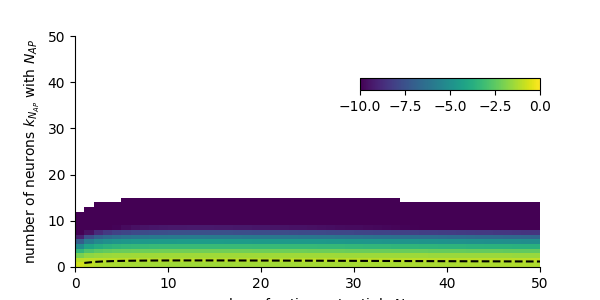

In [ ]:
plt.ion()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
cax = plt.axes([0.6, 0.7, 0.3, 0.04])
cax.set_xlabel("log(p)")

im = ax.imshow(
    np.zeros((n, int(T * nu_max))), clim=[-10, 0], origin="lower", aspect="auto"
)
nu_arr = np.linspace(1 / T, nu_max, int(nu_max * T))
(rho,) = ax.plot(nu_arr * T, rho_nu(nu_arr, gamma, delta, nu_max), color="k", ls="--")

plt.colorbar(im, cax=cax, orientation="horizontal")

plt.setp(
    ax,
    xlim=[0, 50],
    ylim=[0, n / 4],
    xlabel="number of action potentials $N_{AP}$",
    ylabel="number of neurons $k_{N_{AP}}$ with $N_{AP}$",
)
ax.spines[["top", "right"]].set_visible(False)


def update_plot(gamma, delta, nu_max, T, n):
    k_AP = np.arange(n)[:, np.newaxis]
    N_max = int(min(50, nu_max * T))
    N_AP = np.arange(N_max)

    eps_pow = -6
    p_N_AP_arr = quadpy.quad(
        f,
        0,
        nu_max,
        args=(gamma, delta, nu_max, N_AP, T),
        epsabs=10**eps_pow,
        epsrel=10**eps_pow,
        limit=100,
    )[0][np.newaxis, :]

    binom = sp_binom(n, k_AP)

    p_k = binom * p_N_AP_arr**k_AP * (1 - p_N_AP_arr) ** (n - k_AP)

    p_k[p_k < 10 ** (-10)] = np.NaN
    im.set_data(np.log(p_k))
    im.set_extent((0, N_max, 0, n))

    nu_arr = np.linspace(1 / T, N_max / T, N_max)

    rho.set_xdata(nu_arr * T)
    rho.set_ydata(rho_nu(nu_arr, gamma, delta, nu_max) * n / T)


widgets.interactive(
    update_plot,
    gamma=gamma_widget,
    delta=delta_widget,
    nu_max=nu_max_widget,
    T=T_widget,
    n=n_widget,
)